In [ ]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.base import clone, BaseEstimator
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsOneClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
#Loading the MNIST data
mnist = fetch_openml('mnist_784')

X, y = mnist['data'], mnist['target']
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


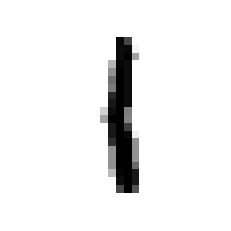

In [ ]:
#Viewing an image from the dataset
some_digit=X[35000]
some_digit_image = some_digit.reshape(28,28) #Reshaping the image in (784 X 1) to (28 X 28)
plt.imshow(some_digit_image, cmap=matplotlib.cm.binary, interpolation="nearest") #Displaying the reshaped image
plt.axis("off")
plt.show()

In [ ]:
#Viewing the label of the image
y[35000] #Tells us the identification label of the above image

'1'

In [ ]:
#Creating the training and testing datasets
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [ ]:
#Performing shuffling of datasets
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

# Training a Binary Classifier

In [ ]:
#Creating a binary classifier to detect whether the number is 9 or not

#Creating the data conditions for the classification
y_train_1 = (y_train == '1') #True for only the digit 9
y_test_1 = (y_test == '1')

In [ ]:
#Creating a SGDClassifier for classification of digit
sgd_classifier = SGDClassifier(random_state=42)
sgd_classifier.fit(X_train, y_train_1) #Fitting the SGD classifier on the training data

#Applying the SGD Classifier to predict digit in the training data
sgd_classifier.predict([some_digit])

array([ True])

In [ ]:
#Creating a classifier that classifies every image as not 1
class Not1Classifier(BaseEstimator):

    def fit(self, X, y=None):
        pass

    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool) 

# Measuring Performance of the Classifier

In [ ]:
#Using cross_validation scores for performance measure
def display_scores(scores):
    print("Scores: {}".format(scores))
    print("Mean: {}".format(scores.mean()))
    print("Std. Deviation: {}".format(scores.std()))

not1_classifier = Not1Classifier() #Creating a Not1Classifer instance
display_scores(cross_val_score(not1_classifier, X_train, y_train_1, cv=3, scoring="accuracy"))

Scores: [0.88745 0.88695 0.8885 ]
Mean: 0.8876333333333334
Std. Deviation: 0.0006459274125025152


Thus, we got ourselves a 88% accurate model on first go. But this is because of the fact that we are just testing whether a particular image is a 1 or not. Since the model only looks if the image is a 1 or not, it is destined to be accurate. That's why in classification problem, performance is measured by other factors not with just accuracy

In [ ]:
#Using cross_validation prediction to get a set of target images
y_train_predictions = cross_val_predict(sgd_classifier, X_train, y_train_1, cv=3) 
y_train_predictions

array([False, False, False, ..., False, False, False])

In [ ]:
#Creating a confusion matrix from the predictions
confusion_matrix(y_train_1, y_train_predictions)

array([[52861,   397],
       [  250,  6492]])

In [ ]:
#Computing performance metrics

#Computing precision 
precision_score(y_train_1, y_train_predictions) # (precision = TP/(TP + FP))

0.9423718972274641

In [ ]:
#Computing recall score
recall_score(y_train_1, y_train_predictions) # (recall = TP/(TP + FN))

0.9629190151290419

In [ ]:
#Computing f1 score
f1_score(y_train_1, y_train_predictions) # (f1 = 2(precision * recall)/(precision + recall))

0.952534663634363

In [ ]:
#Computing all the decision scores for the classifier
y_scores = cross_val_predict(sgd_classifier, X_train, y_train_1, cv=3, method="decision_function")
y_scores

array([-39776.72855602, -49057.66567265, -66771.44898988, ...,
       -97084.93520145, -62565.58969479, -70099.27942786])

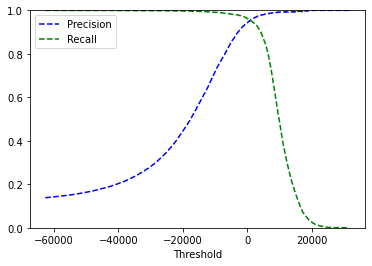

In [ ]:
#Visualizing the precision and recall values for all possible outputs using a precision_recall_curve
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision") #Drawing precisions on the plot against thresholds
    plt.plot(thresholds, recalls[:-1], "g--", label="Recall") #Drawing recalls on the plot against thresholds
    plt.xlabel("Threshold") 
    plt.legend(loc="upper left")
    plt.ylim([0,1])

#Extracting precisions, recalls and thresholds and plotting their graph
precisions, recalls, thresholds = precision_recall_curve(y_train_1, y_scores)
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

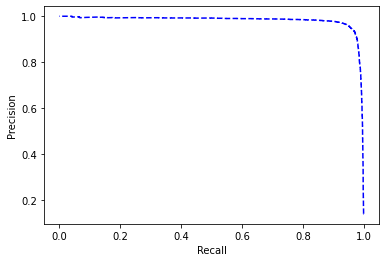

In [ ]:
#Another method to select best precision vs recall values threshold is plotting precision against recalls
plt.plot(recalls, precisions, "b--")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()

In [ ]:
#Selecting the threshold value for the new_predictions
y_train_predictions_90 = (y_scores > 10000)

In [ ]:
#Viewing the precision and recall values for the new predictions
precision_score(y_train_1, y_train_predictions_90)

0.9924721469436917

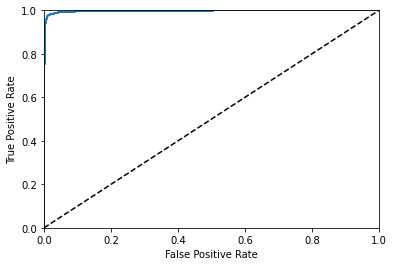

In [ ]:
#Visualizing the ROC curve for the classifier
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0,1], 'k--')
    plt.axis([0,1,0,1])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")

#Extracting precisions, recalls and thresholds and plotting their graph
fpr, tpr, thresholds = roc_curve(y_train_1, y_scores)
plot_roc_curve(fpr, tpr)
plt.show()

In [ ]:
#Computing the area under the curve for the ROC curve
roc_auc_score(y_train_1, y_scores) #Close to 1 represents better classifier

0.9970058577289517

In [ ]:
#Using a Random Forest Classifier for the classification process to compare with SGD
forest_classifier = RandomForestClassifier(random_state=42)

#Computing the probablity prediction for the classifier
y_probas_forest = cross_val_predict(forest_classifier, X_train, y_train_1, cv=3, method="predict_proba")

In [ ]:
#Computing prediciton scores from the probabilities obtained
y_scores_forest = y_probas_forest[:, 1]

#Evaluating values for ROC curve from Random Forest Classifier
fpr_forest, tpr_forest, thresholds = roc_curve(y_train_1, y_scores_forest)

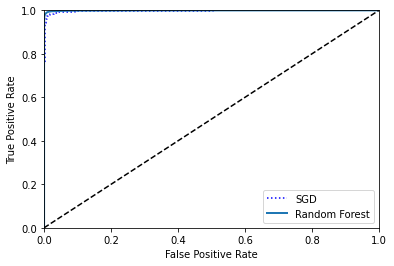

In [ ]:
#Comparing the ROC curve for Random Forest and SGD
plt.plot(fpr, tpr, "b:", label="SGD") #Plotting the SGD values
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest") #Plotting ROC curve for Random Forest
plt.legend(loc = "lower right")
plt.show()

In [ ]:
#Viewing Area under the Curve for Random Forest ROC Curve
roc_auc_score(y_train_1, y_scores_forest)

0.9993188428195021

# Performing MultiClass Classification

In [ ]:
#Performing MultiClass Classification using SGD
sgd_classifier.fit(X_train, y_train)
sgd_classifier.predict([some_digit])

array(['1'], dtype='<U1')

In [ ]:
#Viewing the scores for the SGD Classifier for each class of digits
sgd_some_digit_scores = sgd_classifier.decision_function([some_digit])
sgd_some_digit_scores

array([[-36840.47904166,  12650.67658943,  -7075.25362443,
         -2303.60769418, -10061.6684456 ,  -4953.55965577,
         -8424.62365848, -13845.10077098,  -4438.47438142,
         -3824.67998225]])

In [ ]:
#Viewing the classes for the SGD classifier
sgd_classifier.classes_

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype='<U1')

In [ ]:
#Viewing the class for which we got the highest score
sgd_classifier.classes_[np.argmax(sgd_some_digit_scores)]

'1'

In [ ]:
#Using a Multiclass Classifier using OvO(One vs One) strategy based on SGD
ovo_classifier = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_classifier.fit(X_train, y_train)
ovo_classifier.predict([some_digit])

array(['1'], dtype=object)

In [ ]:
#Checking the number of classifiers trained via OnevsOne technique
len(ovo_classifier.estimators_)

45

In [ ]:
#Training a RandomForest Classifier for Multiclass CLassification
forest_classifier.fit(X_train, y_train)
forest_classifier.predict([some_digit])

array(['1'], dtype=object)

In [ ]:
#Viewing probability predictions obtained by Random Forest
forest_classifier.predict_proba([some_digit])

array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [ ]:
#Cross-validating scores for the classifier
cross_val_score(sgd_classifier, X_train, y_train, cv=3, scoring="accuracy")

array([0.86705, 0.88385, 0.8764 ])

# Error Analysis

In [ ]:
#Computing the confusion matrix for the classifier
y_train_predictions = cross_val_predict(sgd_classifier, X_train, y_train, cv=3)
conf_matrix = confusion_matrix(y_train, y_train_predictions)
conf_matrix

array([[5642,    1,   16,   44,   13,   45,   51,   12,   89,   10],
       [   2, 6376,   38,   34,   13,   40,   37,   12,  160,   30],
       [  59,   62, 4807,  284,   77,   51,  179,   81,  337,   21],
       [  30,   21,  118, 5381,   17,  188,   32,   54,  224,   66],
       [  13,   19,   29,   15, 5219,   37,   39,   33,  106,  332],
       [  59,   13,   27,  303,   93, 4280,  139,   34,  418,   55],
       [  51,    5,   57,   19,   45,  136, 5482,    5,  110,    8],
       [  18,   21,   63,   65,   86,   19,    3, 5646,   67,  277],
       [  39,   92,   63,  172,   24,  392,   64,   28, 4880,   97],
       [  26,   11,   31,   96,  278,   88,    0,  322,  264, 4833]])

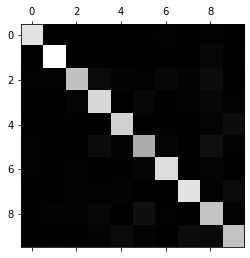

In [ ]:
#Visualizing the confusion matrix
plt.matshow(conf_matrix, cmap=plt.cm.gray)
plt.show()

In [ ]:
#Normalizing the confusion matrix 
row_sums = conf_matrix.sum(axis=1, keepdims=True) #Summing the total number of images in a particular class
norm_matrix = conf_matrix / row_sums #Computing the normalized matrix

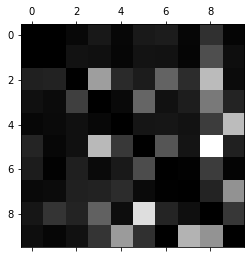

In [ ]:
#Visualizing the normalized matrix
np.fill_diagonal(norm_matrix, 0) #Removing the diagonal values (correct results) to view only the error values
plt.matshow(norm_matrix, cmap=plt.cm.gray)
plt.show()

# MultiLabel Classification

In [ ]:
#Creating conditions for Multilabels in MNIST dataset
y_train_greater_6 = (y_train.astype(np.int64) > 6)
y_train_odd = (y_train.astype(np.int64) % 2 == 1)

#Creating a multilabel using the conditions
y_multilabel = np.c_[y_train_greater_6, y_train_odd]

In [ ]:
#Applying Multilabel classification using KNeighbours Classifier
knn_classifier = KNeighborsClassifier()
knn_classifier.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [ ]:
#Predicting multilabels using KNeighbours Classifier
knn_classifier.predict([some_digit])

array([[False,  True]])

# Multiobject Classification

In [ ]:
#Creating noise for images for multi-object classification
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise #Creating a noisy training dataset

noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise #Creating a noisy testing dataset

#Creating instances for the actual dataset
y_train_mod = X_train
y_test_mod = X_test

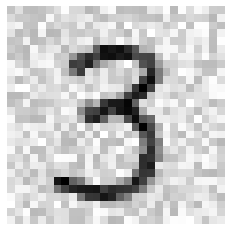

In [ ]:
#Viewing image from noisy dataset
some_digit=X_train_mod[5000]
some_digit_image = some_digit.reshape(28,28) #Reshaping the image in (784 X 1) to (28 X 28)
plt.imshow(some_digit_image, cmap=matplotlib.cm.binary, interpolation="nearest") #Displaying the reshaped image
plt.axis("off")
plt.show()

In [ ]:
#Applying KNeighbours Classifier and cleaning the image
knn_classifier.fit(X_train_mod, y_train_mod)
clean_digit = knn_classifier.predict([some_digit])

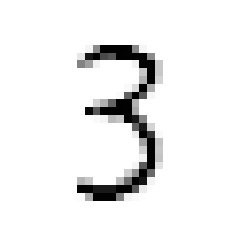

In [ ]:
#Viewing the clean
clean_digit = clean_digit.reshape(28,28) #Reshaping the image in (784 X 1) to (28 X 28)
plt.imshow(clean_digit, cmap=matplotlib.cm.binary, interpolation="nearest") #Displaying the reshaped image
plt.axis("off")
plt.show()